# Fitting

There are two built in fitting engines, `lmfit` and `bumps`.

Set the current directory.

In [1]:
import os
tests_path = os.getcwd()
os.chdir(os.path.join(os.getcwd(), '..'))
eDL_path = os.getcwd()
print("Test path:", tests_path)
print("easyDiffractionLib path:", eDL_path)

Test path: D:\projects\easyScience\easyDiffractionLib\tests
easyDiffractionLib path: D:\projects\easyScience\easyDiffractionLib


Import all the packages.

In [2]:
# Import all the packages
from easyCore import np
from easyDiffractionLib.sample import Sample
from easyDiffractionLib import Phases
from easyDiffractionLib.interface import InterfaceFactory
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters
from easyDiffractionLib.Elements.Experiments.Pattern import Pattern1D

from easyCore.Fitting.Fitting import Fitter

import matplotlib.pyplot as plt

## Preparing the sample and data

We load up a cif file and then set the experimental parameters.

In [3]:
interface = InterfaceFactory()
cif_path = os.path.join(tests_path, 'PbSO4.cif')
print('cif_path:', cif_path)
c = Phases.from_cif_file(cif_path)
S = Sample(phases=c, parameters=Instrument1DCWParameters.default(), pattern=Pattern1D.default(), interface=interface)

cif_path: D:\projects\easyScience\easyDiffractionLib\tests\PbSO4.cif
Temp CIF: C:\Users\PIOTRR~1\AppData\Local\Temp\easydiffraction_temp.cif


We can load up some experimental data

In [4]:
xye_path = os.path.join(tests_path, 'PbSO4_xrays_short.xye')
print('xye_path:', xye_path)
data_x, data_y, data_e = np.loadtxt(xye_path, unpack=True)
data_y = data_y/100.0
print('data_x:', data_x)
print('data_y:', data_y)
print('data_e:', data_e)

xye_path: D:\projects\easyScience\easyDiffractionLib\tests\PbSO4_xrays_short.xye
data_x: [ 10.     10.025  10.05  ... 119.95  119.975 120.   ]
data_y: [1.79 1.47 1.65 ... 1.63 1.64 1.66]
data_e: [13.3791 12.1244 12.8452 ... 12.7671 12.8062 12.8841]


Generate the simulation y-data

In [5]:
sim_y_data = interface.fit_func(data_x)

AttributeError: 'NoneType' object has no attribute 'backgrounds'

In [ ]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

In [ ]:
We can load up some experimental data

Generate the simulation y-data

In [5]:
sim_y_data = interface.fit_func(data_x)

<IPython.core.display.Javascript object>


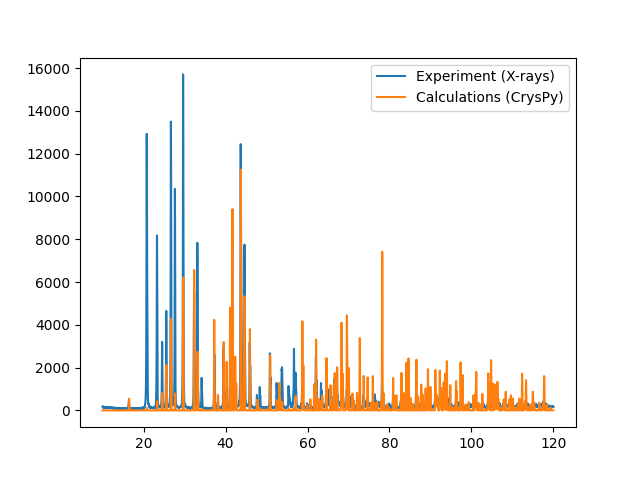

In [6]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

We can load up some experimental data

Generate the simulation y-data

In [8]:
sim_y_data = interface.fit_func(data_x)

<IPython.core.display.Javascript object>


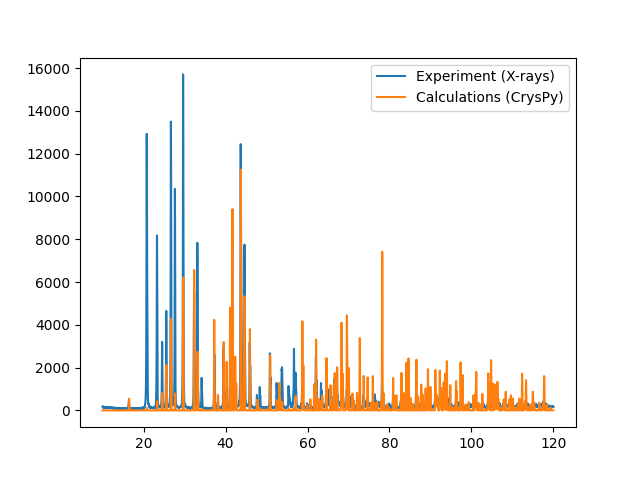

In [9]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

We can load up some experimental data

In [10]:
xye_path = os.path.join(tests_path, 'PbSO4_xrays_short.xye')
print('xye_path:', xye_path)
data_x, data_y, data_e = np.loadtxt(xye_path, unpack=True)
print('data_x:', data_x)
print('data_y:', data_y)
print('data_e:', data_e)

xye_path: /home/simonward/PycharmProjects/easyScience/easyDiffractionLib/tests/PbSO4_xrays_short.xye
data_x: [ 10.     10.025  10.05  ... 119.95  119.975 120.   ]
data_y: [179. 147. 165. ... 163. 164. 166.]
data_e: [13.379 12.124 12.845 ... 12.767 12.806 12.884]


Generate the simulation y-data

In [11]:
sim_y_data = interface.fit_func(data_x)

<IPython.core.display.Javascript object>


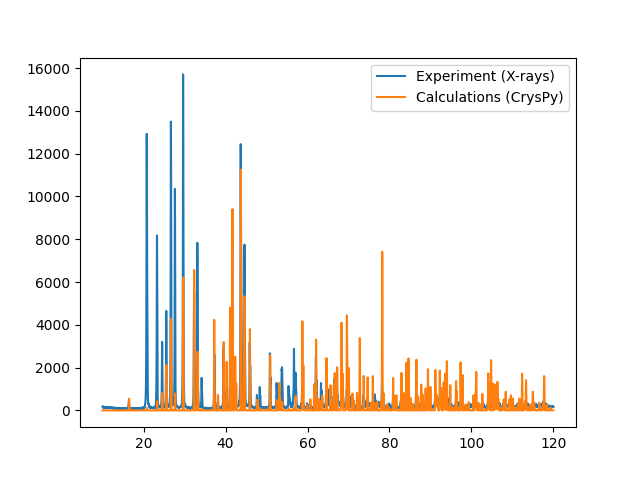

In [12]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

We do not have the correct experimental parameters..

<IPython.core.display.Javascript object>


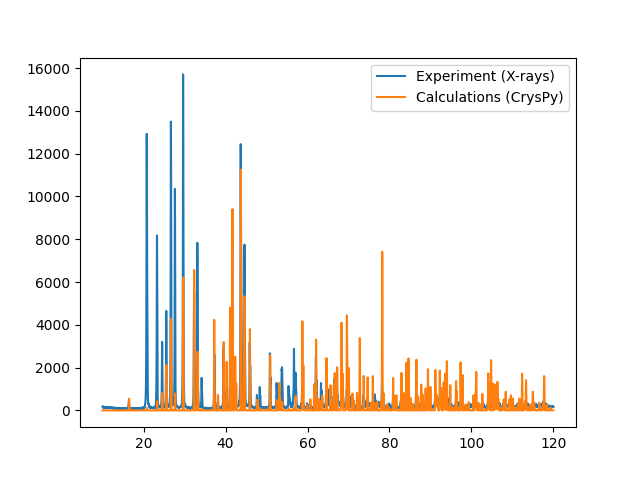

In [13]:
S.parameters.wavelength = 1.54
S.parameters.u_resolution = 0.031
S.parameters.v_resolution = -0.052
S.parameters.w_resolution = 0.032
S.parameters.x_resolution = 0.015
S.parameters.y_resolution = 0.0

#sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Now we need to set the background

In [14]:
from easyDiffractionLib.Elements.Backgrounds.Point import PointBackground, BackgroundPoint

bg = PointBackground(linked_experiment='PbSO4')
bg.append(BackgroundPoint.from_pars(data_x[0], 166))
bg.append(BackgroundPoint.from_pars(16, 36))
bg.append(BackgroundPoint.from_pars(50, 120))
bg.append(BackgroundPoint.from_pars(100, 100))
bg.append(BackgroundPoint.from_pars(data_x[-1], 164))
print(bg)

S.set_background(bg)
print(S.backgrounds)

Background of 5 points.
Collection of 1 backgrounds.


<IPython.core.display.Javascript object>


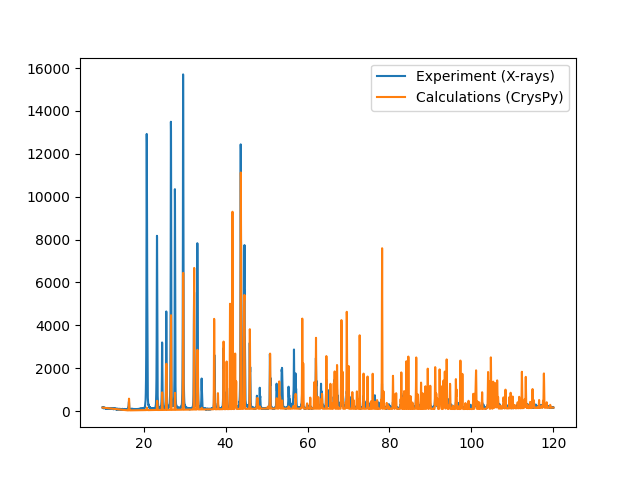

In [15]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Select CrysFML calculator

In [16]:
print(interface.available_interfaces)
print(interface.current_interface_name)
interface.switch('CrysFML')
S._updateInterface()
print(interface.current_interface_name)

['CrysPy', 'CrysFML', 'GSAS-II']
CrysPy
CrysFML


<IPython.core.display.Javascript object>


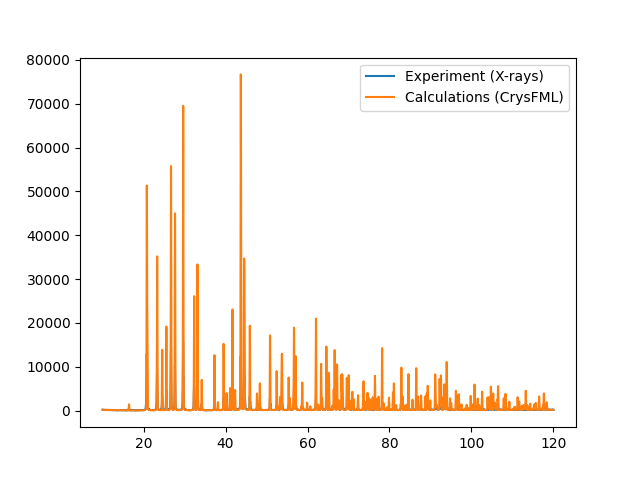

In [17]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Change scale manually

In [ ]:
S.pattern.scale = 0.1
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

## Fitting to the data

Initalize the fitting engine and apply a few constraints

In [ ]:
f = Fitter(S, interface.fit_func)

# Vary the scale and the BG points
S.pattern.scale.fixed = False
S.pattern.zero_shift.fixed = False
#S.parameters.resolution_u.fixed = False
#S.parameters.resolution_v.fixed = False
#S.parameters.resolution_w.fixed = False
#S.parameters.resolution_x.fixed = False
#S.backgrounds[0][0].y.fixed = False
#S.backgrounds[0][1].y.fixed = False
#S.backgrounds[0][2].y.fixed = False
#S.backgrounds[0][3].y.fixed = False
#S.backgrounds[0][4].y.fixed = False

Select bumps minimizer

In [ ]:
print("available minimizers:", f.available_engines)
print()
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())
print()
print("switch minimizer")
f.switch_engine('bumps')
f_method = 'lm'
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())

Perform the fit

In [ ]:
result = f.fit(data_x, data_y, weights=1/data_e, method=f_method)

In [ ]:
if result.success:
    print("The fit has been successful: {}".format(result.success))
    print("The gooodness of fit is: {}".format(result.goodness_of_fit))
    
sim_y_data = interface.fit_func(data_x)

In [ ]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experimental')
plt.plot(data_x, sim_y_data, label='Best Fit')
plt.legend()

In [ ]:
print(f'Scale: {S.pattern.scale}')
print(f'Scale: {S.pattern.zero_shift}')